# CNN을 활용한 MNIST 이미지 분류

## #01. 준비작업

### [1] 패키지 준비하기


In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 준비하기


In [3]:
(x_train, y_train), (x_test, y_test) = load_data(path="mnist.npz")

> 결측치 등의 데이터 이상점이 없는 예제 데이터이고, 이미 앞의 예제를 통해 데이터 형태를 확인하였으므로 이미지를 살펴보는 과정은 생략
>  
> 불러들인 데이터셋 자체가 훈련/검증 데이터로 구분되어 있으므로 데이터 분리 과정 생략


## #02. 데이터 전처리

### [1] 레이블에 대한 one-hot-encoding


In [4]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### [2] 훈련, 검증용 독립변수(이미지)의 차수 재설정

기본 CNN 골격에 맞게 28x28x1로 차원을 변경


In [5]:
x_train_reshape = x_train.reshape(
    x_train.shape[0], x_train.shape[1], x_train.shape[2], 1
)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(f"훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_test_reshape.shape}")

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (10000, 28, 28, 1)


### [3] 이미지 데이터 정규화

이미지와 같이 복잡한 데이터의 경우 BatchNormalization층을 적용하여 텐서플로우 모델 구성시 표준화를 수행하는 학습층을 추가할 수 있다.

그 경우 독립변수 데이터를 직접 표준화 할 필요가 없다.

BatchNormalization은 입력 데이터를 정규화(normalize)하고, 이에 대해 활성화 함수를 적용하기 전에 스케일링(scale) 및 이동(shift)을 수행합니다. 이렇게 스케일링 및 이동된 데이터는 활성화 함수의 입력으로 사용된다.

따라서, BatchNormalization은 Activation 레이어 이전에 사용되어야 한다.

만약 BatchNormalization을 Activation 레이어 이후에 적용한다면, 정규화된 데이터가 활성화 함수에 대해 스케일링 및 이동되기 전에 활성화 함수의 입력으로 사용되기 때문에, BatchNormalization을 적용하는 의미가 퇴색되며, 오히려 모델 성능을 떨어뜨릴 수 있다.

## #04. 훈련 모델 적합

### [1] 모델 정의

( `Conv2D 적용 [-> BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout]` )의 과정을 n번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

* **Conv2D 층**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기
* **BatchNormalization (배치정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.
* **MaxPool2D**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.


In [6]:
model = Sequential()

# ------------------------#
# Conv2D
model.add(
    Conv2D(
        filters=32,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding="same",
        input_shape=(28, 28, 1),
    )
)

# 표준화
model.add(BatchNormalization())

# Activation
model.add(Activation("relu"))

# MaxPool2D
model.add(MaxPool2D(pool_size=(2, 2)))

# 랜덤으로 5%의 뉴런을 쉬게함
model.add(Dropout(0.05))

# ------------------------#

# 1차원으로 변환하기 위한 Layer --> Dense Layer을 쌓기 전 마지막 처리
model.add(Flatten())

model.add(Dense(256))

# 표준화
model.add(BatchNormalization())

# Activation
model.add(Activation("relu"))

# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       401,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,930 (1.55 MB)

 Trainable params: 405,354 (1.55 MB)

 Non-trainable params: 576 (2.25 KB)

### 학습하기


+-------+----------+------------+
|       |      acc |       loss |
|-------+----------+------------|
| train | 0.997833 | 0.00653867 |
| test  |   0.9899 |  0.0375257 |
+-------+----------+------------+


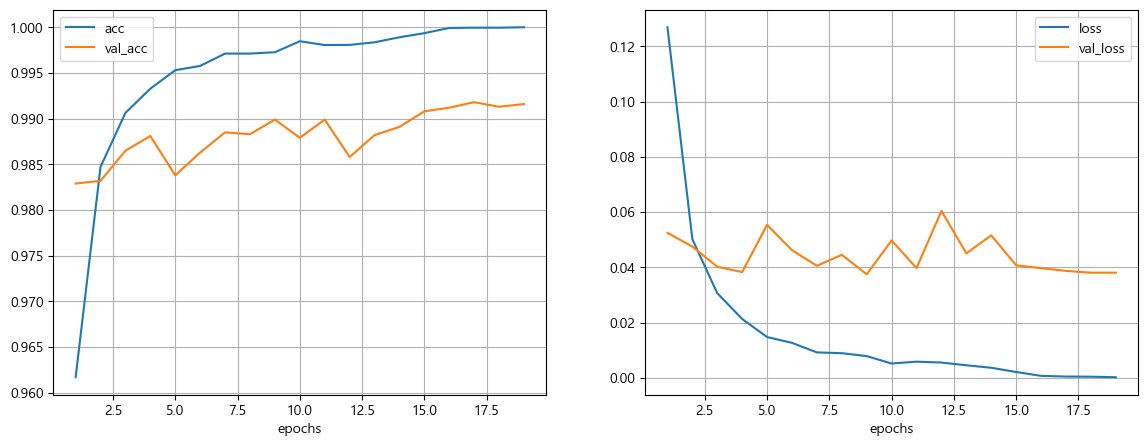

CPU times: total: 14min 15s
Wall time: 2min 38s


In [7]:
%%time

result = tf_train(model, x_train_reshape, y_train_one_hot, x_test_reshape, y_test_one_hot)

tf_result(result)

## #05. 학습 결과 적용

### [1] 훈련 데이터에 대한 예측 결과 산정


In [8]:
result = model.predict(x_test_reshape)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([4.7448781e-12, 5.5322357e-12, 1.0355155e-10, 1.5503704e-11,
       1.5700876e-12, 7.5471618e-15, 1.2565906e-13, 1.0000000e+00,
       4.2301301e-10, 1.2467162e-10], dtype=float32)

### [2] 가장 큰 확률 값의 인덱스를 별도 리스트로 추출


In [9]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

### [3] 데이터 비교


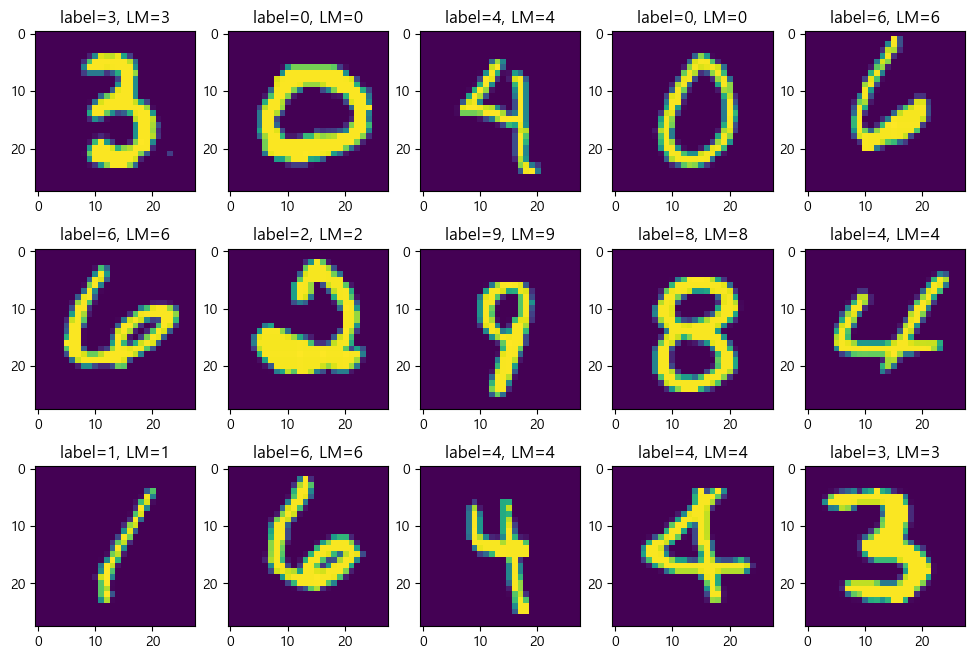

In [10]:
row = 3
col = 5
fig, ax = plt.subplots(row, col, figsize=((col + 1) * 2, (row + 1) * 2), dpi=100)

size = row * col
length = len(x_test)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_test[k]
    label = y_test[k]
    ax[i // col][i % col].imshow(train)
    ax[i // col][i % col].set_title("label=%d, LM=%d" % (label, arg_result[k]))

plt.show()
plt.close()

### 혼동행렬


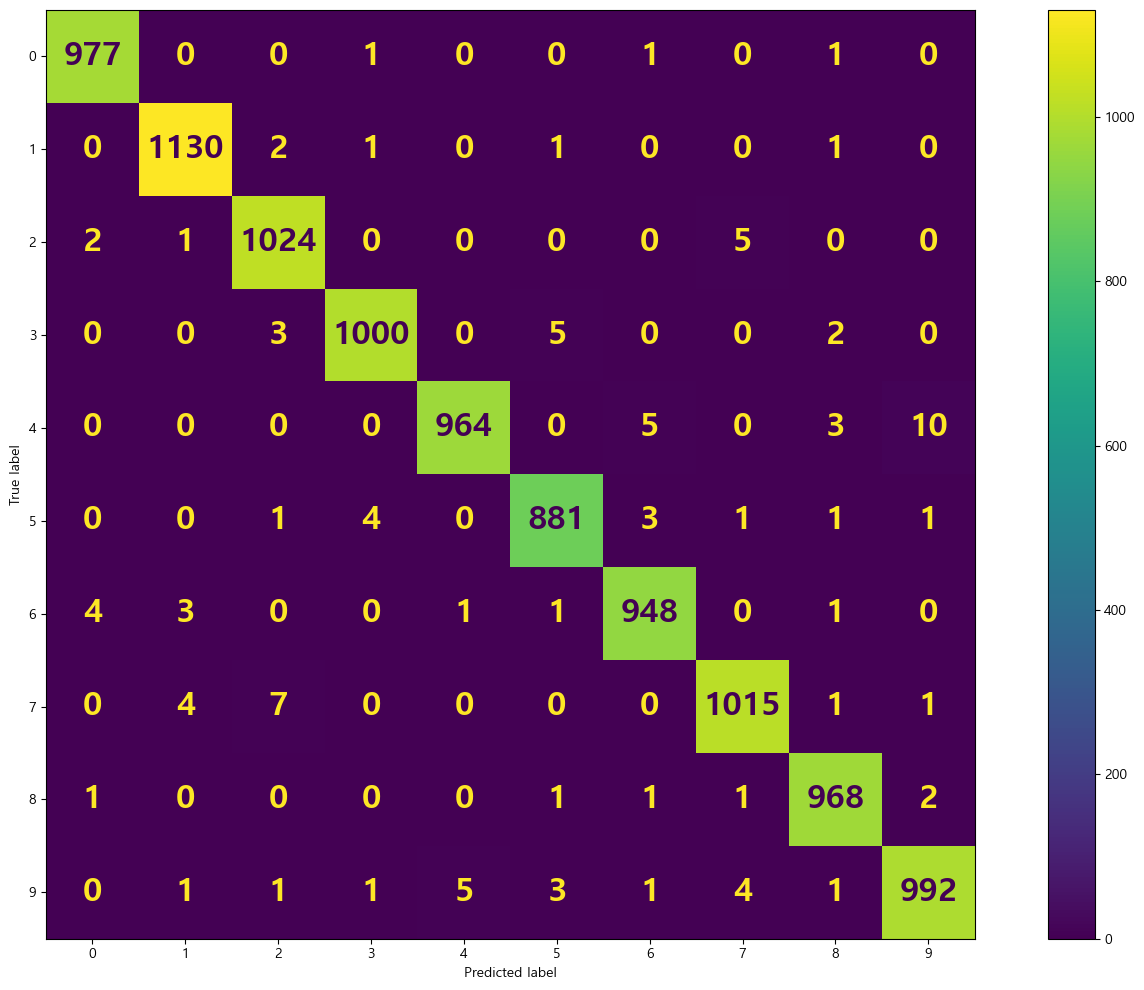

In [11]:
my_confusion_matrix(y_test, arg_result, figsize=(15, 10), dpi=100)